In [1]:
import typing as t
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from torch.utils.data import Dataset, DataLoader

In [2]:
# @formatter:off
%matplotlib inline
# @formatter:on

In [3]:
torch.set_warn_always(True)

sns.set_theme()
plt.rcParams["figure.figsize"] = (8, 4)

In [4]:
DATA_DIR = Path("../data/")

CUDA = "cuda"
CPU = "cpu"
DEVICE = CUDA if torch.cuda.is_available() else CPU
print(f"Using {DEVICE.upper()} device")

Using CUDA device


## Предобработка данных и подготовка датасета

In [5]:
def na_stat(df: pd.DataFrame) -> pd.Series:
    stat = df.isna().sum()
    return stat[stat > 0]


def duplicates_stat(df: pd.DataFrame) -> pd.Series:
    return df[df.duplicated()].value_counts()


def get_categorical_columns(df: pd.DataFrame) -> pd.Index:
    return df.select_dtypes(object).columns


def get_numerical_columns(df: pd.DataFrame) -> pd.Index:
    return df.select_dtypes(np.number).columns


def count_categories(df: pd.DataFrame) -> pd.Series:
    return df[get_categorical_columns(df)].nunique()

In [6]:
insurance_df: pd.DataFrame = pd.read_csv(DATA_DIR / "regression/insurance.csv")
print(insurance_df.shape)
insurance_df.head()

(1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [7]:
na_stat(insurance_df)

Series([], dtype: int64)

In [8]:
duplicates_stat(insurance_df)

age  sex   bmi    children  smoker  region     charges  
19   male  30.59  0         no      northwest  1639.5631    1
dtype: int64

In [9]:
insurance_df = insurance_df.drop_duplicates()
duplicates_stat(insurance_df)

Series([], dtype: int64)

In [10]:
count_categories(insurance_df)

sex       2
smoker    2
region    4
dtype: int64

In [11]:
print(insurance_df.shape)
insurance_df.head()

(1337, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [12]:
class InsuranceDataset(Dataset):
    encoder: OrdinalEncoder
    scaler: StandardScaler
    num_features: int
    data: torch.Tensor
    targets: torch.Tensor

    def __init__(self, df: pd.DataFrame, encoder: OrdinalEncoder = None, scaler: StandardScaler = None):
        if encoder:
            self.encoder = encoder
            encode = self.encoder.transform
        else:
            self.encoder = OrdinalEncoder()
            encode = self.encoder.fit_transform

        if scaler:
            self.scaler = scaler
            scale = self.scaler.transform
        else:
            self.scaler = StandardScaler()
            scale = self.scaler.fit_transform

        target_col = "charges"
        data, targets = df.drop(columns=[target_col]), df[target_col]

        encode_cols, scale_cols = get_categorical_columns(data), get_numerical_columns(data)
        data[encode_cols] = encode(data[encode_cols])
        data[scale_cols] = scale(data[scale_cols])

        self.data = torch.tensor(data.to_numpy(), dtype=torch.float)
        self.targets = torch.tensor(targets.to_numpy(), dtype=torch.float).unsqueeze(1)
        self.num_features = self.data.size(1)

    def __len__(self):
        return self.targets.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [13]:
train_df, test_df = train_test_split(insurance_df, test_size=0.2, random_state=0)

train_dataset = InsuranceDataset(train_df)
test_dataset = InsuranceDataset(
    test_df,
    encoder=train_dataset.encoder,
    scaler=train_dataset.scaler,
)
len(train_dataset), len(test_dataset), train_dataset.num_features

(1069, 268, 6)

## Построение и обучение модели

In [14]:
def common_train(
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        epochs: int,
        train_dataloader: DataLoader,
        test_dataloader: DataLoader,
        verbose: int = None,
        device: str = CPU,
) -> t.Tuple[t.List[float], t.List[float], t.List[float], t.List[float]]:
    train_losses, train_r2s = [], []
    test_losses, test_r2s = [], []
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}\n" + "-" * 32)

        train_loss, train_r2 = train_loop(train_dataloader, model, loss_fn, optimizer, verbose=verbose, device=device)
        print(f"Train Error: loss: {train_loss:.6f}, R^2: {train_r2:.4f}")
        train_losses.append(train_loss)
        train_r2s.append(train_r2)

        test_loss, test_r2 = test_loop(test_dataloader, model, loss_fn, device=device)
        print(f" Test Error: loss: {test_loss:.6f}, R^2: {test_r2:.4f}\n")
        test_losses.append(test_loss)
        test_r2s.append(test_r2)

        torch.cuda.empty_cache()
    return train_losses, train_r2s, test_losses, test_r2s


def train_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        verbose: int = None,
        device: str = CPU,
) -> t.Tuple[float, float]:
    model.train()

    size = len(dataloader.dataset)  # noqa
    num_batches = len(dataloader)
    avg_loss, avg_r2 = 0, 0

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        r2 = metrics.r2_score(y.detach().cpu(), pred.detach().cpu())
        avg_loss += loss
        avg_r2 += r2
        if verbose and batch % verbose == 0:
            print(f"[{batch * len(x):>4d}/{size:>4d}]: loss: {loss:.6f}, R^2: {r2:.4f}")

        del x, y, pred, loss
        torch.cuda.empty_cache()

    return (avg_loss / num_batches).item(), avg_r2 / num_batches


@torch.no_grad()
def test_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        device: str = CPU,
) -> t.Tuple[float, float]:
    model.eval()
    y_true, y_pred = get_y_true_y_pred(model, dataloader, device)
    return loss_fn(y_pred, y_true).item(), metrics.r2_score(y_true, y_pred)


@torch.no_grad()
def get_y_true_y_pred(
        model: nn.Module,
        dataloader: DataLoader,
        device: str = CPU,
) -> t.Tuple[torch.Tensor, torch.Tensor]:
    model.eval()

    y_test = []
    y_pred = []
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        y_test.append(y)
        y_pred.append(pred)

        del x
        torch.cuda.empty_cache()

    return torch.flatten(torch.vstack(y_test)).cpu(), torch.flatten(torch.vstack(y_pred)).cpu()


def plot_train_test(
        train_losses: t.List[float],
        train_r2s: t.List[float],
        test_losses: t.List[float],
        test_r2s: t.List[float],
) -> None:
    fig, axes = plt.subplots(2, 1, figsize=(6, 7))
    epochs = torch.arange(len(train_losses))

    axes[0].plot(epochs, train_losses)
    axes[0].plot(epochs, test_losses)
    axes[0].set_ylabel("loss")
    axes[0].legend(["train", "test"])

    axes[1].plot(epochs, train_r2s)
    axes[1].plot(epochs, test_r2s)
    axes[1].set_xlabel("epoch")
    axes[1].set_ylabel("$R^2$")


def plot_y_true_y_pred(y_true: torch.Tensor, y_pred: torch.Tensor):
    x = torch.arange(len(y_pred))
    plt.plot(x, y_true)
    plt.plot(x, y_pred)
    plt.legend(["true", "pred"])

In [15]:
class InsuranceRegression(nn.Module):

    def __init__(self, num_features: int):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256, 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.mlp(x)

In [16]:
torch.manual_seed(0)

net = InsuranceRegression(train_dataset.num_features).to(DEVICE)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.005)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

net

InsuranceRegression(
  (mlp): Sequential(
    (0): Linear(in_features=6, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [17]:
%%time

train_losses, train_r2s, test_losses, test_r2s = common_train(
    epochs=200,
    model=net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    device=DEVICE,
)

Epoch 1
--------------------------------
Train Error: loss: 322045376.000000, R^2: -1.2272
 Test Error: loss: 353872928.000000, R^2: -1.1035

Epoch 2
--------------------------------
Train Error: loss: 272725024.000000, R^2: -0.9591
 Test Error: loss: 252853072.000000, R^2: -0.5030

Epoch 3
--------------------------------
Train Error: loss: 157590096.000000, R^2: -0.1196
 Test Error: loss: 141172704.000000, R^2: 0.1608

Epoch 4
--------------------------------
Train Error: loss: 133099112.000000, R^2: 0.0572
 Test Error: loss: 119430576.000000, R^2: 0.2901

Epoch 5
--------------------------------
Train Error: loss: 105048176.000000, R^2: 0.2353
 Test Error: loss: 96121016.000000, R^2: 0.4286

Epoch 6
--------------------------------
Train Error: loss: 87588920.000000, R^2: 0.3817
 Test Error: loss: 73869408.000000, R^2: 0.5609

Epoch 7
--------------------------------
Train Error: loss: 70415760.000000, R^2: 0.4798
 Test Error: loss: 62473592.000000, R^2: 0.6286

Epoch 8
------------

## Оценка и выводы

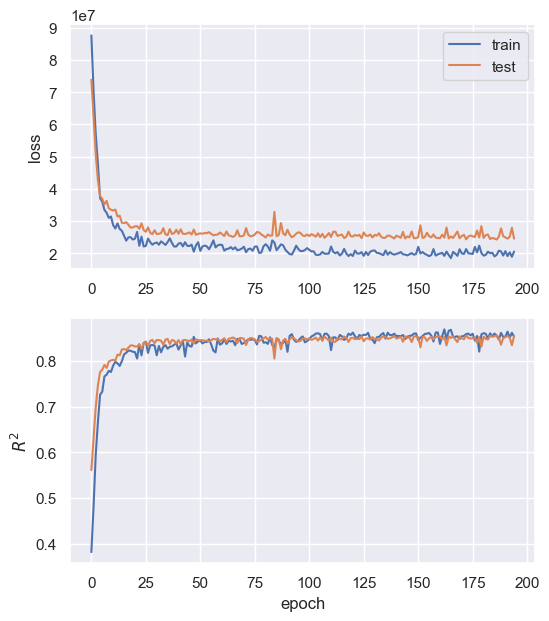

In [18]:
plot_train_test(train_losses[5:], train_r2s[5:], test_losses[5:], test_r2s[5:])

In [19]:
y_true, y_pred = get_y_true_y_pred(net, test_dataloader, DEVICE)

r2 = metrics.r2_score(y_true, y_pred)
mse = metrics.mean_squared_error(y_true, y_pred)  # тоже самое что и nn.MSELoss
rmse = np.sqrt(mse)
mae = metrics.mean_absolute_error(y_true, y_pred)
mape = metrics.mean_absolute_percentage_error(y_true, y_pred)
rmsle = np.sqrt(metrics.mean_squared_log_error(y_true, y_pred))
print(f"  R^2: {r2:.6f}")
print(f"  MSE: {mse:.6f}")
print(f" RMSE: {rmse:.6f}")
print(f"  MAE: {mae:.6f}")
print(f" MAPE: {mape:.6f}")
print(f"RMSLE: {rmsle:.6f}")

  R^2: 0.853969
  MSE: 24566722.000000
 RMSE: 4956.482910
  MAE: 2964.722900
 MAPE: 0.320170
RMSLE: 0.410134


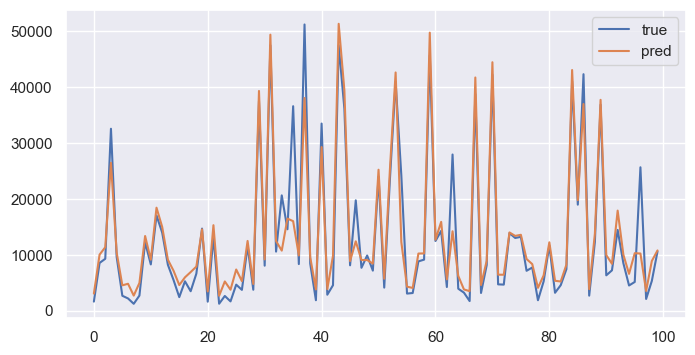

In [20]:
plot_y_true_y_pred(y_true[:100], y_pred[:100])

In [21]:
net.eval()
for i in torch.randperm(len(test_dataset))[:5]:
    x, y = test_dataset[i]
    x, y = x.to(DEVICE), y.to(DEVICE)
    pred = net(x.unsqueeze(0)).squeeze(0)
    print(f"Input:   {x.cpu()}")
    print(f"Target:  {y.item():.6f}")
    print(f"Predict: {pred.item():.6f}\n")

Input:   tensor([-0.8722,  1.0000, -0.0774,  1.5991,  0.0000,  3.0000])
Target:  4260.744141
Predict: 4734.300293

Input:   tensor([-1.3686,  0.0000,  0.3676, -0.8976,  0.0000,  2.0000])
Target:  1880.069946
Predict: 4097.953125

Input:   tensor([-1.1559,  0.0000, -1.2510,  0.7668,  0.0000,  1.0000])
Target:  14426.074219
Predict: 6072.016113

Input:   tensor([0.9713, 0.0000, 0.2523, 0.7668, 0.0000, 0.0000])
Target:  29186.482422
Predict: 12991.247070

Input:   tensor([0.6168, 1.0000, 0.8003, 2.4313, 0.0000, 0.0000])
Target:  10736.871094
Predict: 12540.255859

